In [31]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
import re
import lfrData

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [32]:
G_lfr=nx.Graph()
data,labels=lfrData.load_data(0.5)

for index,item in enumerate(labels):
    G_lfr.add_node(index+1,value=item)
for item in data:
    G_lfr.add_edge(*item)
B_lfr = nx.modularity_matrix(G_lfr)

In [33]:
c_attributes = nx.get_node_attributes(G_lfr,'value')
print(c_attributes)

{1: 1, 2: 4, 3: 4, 4: 4, 5: 1, 6: 1, 7: 4, 8: 1, 9: 1, 10: 2, 11: 1, 12: 2, 13: 2, 14: 3, 15: 2, 16: 2, 17: 2, 18: 2, 19: 1, 20: 4, 21: 4, 22: 3, 23: 1, 24: 1, 25: 3, 26: 3, 27: 4, 28: 1, 29: 2, 30: 3, 31: 4, 32: 2, 33: 3, 34: 1, 35: 3, 36: 1, 37: 4, 38: 3, 39: 4, 40: 1, 41: 3, 42: 2, 43: 1, 44: 4, 45: 4, 46: 2, 47: 4, 48: 2, 49: 3, 50: 2, 51: 4, 52: 2, 53: 3, 54: 3, 55: 2, 56: 2, 57: 4, 58: 4, 59: 1, 60: 1, 61: 3, 62: 2, 63: 3, 64: 3, 65: 3, 66: 4, 67: 1, 68: 4, 69: 2, 70: 1, 71: 1, 72: 1, 73: 3, 74: 3, 75: 2, 76: 2, 77: 3, 78: 3, 79: 1, 80: 3, 81: 4, 82: 3, 83: 3, 84: 3, 85: 4, 86: 4, 87: 1, 88: 4, 89: 2, 90: 4, 91: 1, 92: 4, 93: 4, 94: 3, 95: 4, 96: 2, 97: 4, 98: 3, 99: 2, 100: 3, 101: 1, 102: 1, 103: 1, 104: 2, 105: 1, 106: 1, 107: 3, 108: 2, 109: 1, 110: 2, 111: 2, 112: 4, 113: 1, 114: 3, 115: 3, 116: 4, 117: 3, 118: 3, 119: 2, 120: 2, 121: 4, 122: 2, 123: 1, 124: 2, 125: 4, 126: 4, 127: 1, 128: 2}


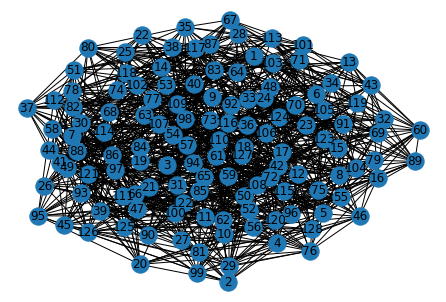

In [34]:
nx.draw(G_lfr,with_labels=True)

In [35]:
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [36]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        # activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.1)(activation)
        code = self.encoder_output_layer(activation)
        # code = torch.tanh(code)
        # code = nn.Dropout(p=0.1)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        # activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.1)(activation)
        activation = self.decoder_output_layer(activation)
        # reconstructed = torch.tanh(activation)
        return encoder,activation

In [37]:
learning_rate = 1e-4

In [38]:
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=128)
model2=AE(hidden_layers=32,in_layers=64)
model3=AE(hidden_layers=16,in_layers=32)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model1)
print(model2)
print(model3)

AE(
  (encoder_hidden_layer): Linear(in_features=128, out_features=64, bias=True)
  (encoder_output_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_hidden_layer): Linear(in_features=64, out_features=64, bias=True)
  (decoder_output_layer): Linear(in_features=64, out_features=128, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)
AE(
  (encoder_hidden_layer): Linear(in_features=32, out_features=16, bias=True)
  (encoder_output_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_hidden_layer): Linear(in_features=16, out_features=16, bias=True)
  (decoder_output_layer): Linear(in_features=16, out_features=32, bias=True)
)


In [39]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [40]:
B_lfr=np.asarray(B_lfr,dtype=np.float64)
inputs=torch.from_numpy(B_lfr)
targets=torch.from_numpy(B_lfr)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(5000,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(5000,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)
# AE 3 training
# encoder,hist=train_model(200,train_dl,model3,optimizer3)
# train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder.detach().shape)

epoch : 1/5000, recon loss = 0.11801350
epoch : 2/5000, recon loss = 0.11781184
epoch : 3/5000, recon loss = 0.11761246
epoch : 4/5000, recon loss = 0.11741538
epoch : 5/5000, recon loss = 0.11722056
epoch : 6/5000, recon loss = 0.11702801
epoch : 7/5000, recon loss = 0.11683769
epoch : 8/5000, recon loss = 0.11664960
epoch : 9/5000, recon loss = 0.11646371
epoch : 10/5000, recon loss = 0.11627999
epoch : 11/5000, recon loss = 0.11609840
epoch : 12/5000, recon loss = 0.11591892
epoch : 13/5000, recon loss = 0.11574151
epoch : 14/5000, recon loss = 0.11556612
epoch : 15/5000, recon loss = 0.11539274
epoch : 16/5000, recon loss = 0.11522130
epoch : 17/5000, recon loss = 0.11505176
epoch : 18/5000, recon loss = 0.11488410
epoch : 19/5000, recon loss = 0.11471825
epoch : 20/5000, recon loss = 0.11455417
epoch : 21/5000, recon loss = 0.11439182
epoch : 22/5000, recon loss = 0.11423115
epoch : 23/5000, recon loss = 0.11407212
epoch : 24/5000, recon loss = 0.11391468
epoch : 25/5000, recon lo

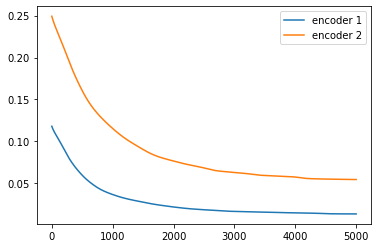

In [41]:
plt.plot(hist1,label='encoder 1')
plt.plot(hist2,label='encoder 2')
plt.legend()
plt.show()

In [42]:
B_lfr_X=encoder.detach().numpy()

In [43]:
print(type(B_lfr_X),B_lfr_X)

<class 'numpy.ndarray'> [[ 0.41887522  0.6204806   0.39537084 ... -0.5850208   0.7308211
   0.24190924]
 [ 0.26298022 -1.1176053   0.7546816  ... -0.40836734 -1.2386928
  -0.11211961]
 [-0.1541644  -0.01702788  0.20121177 ... -0.5084177   0.8139052
  -0.5478196 ]
 ...
 [-0.12078236 -0.28984633 -0.691918   ... -0.57360953 -0.4778756
   0.01444958]
 [-0.02651829 -0.5218473  -0.75601643 ...  0.1351997  -0.21681213
   0.29723203]
 [-1.0110946   0.7933397  -0.9391327  ... -0.4986756  -0.9901015
  -0.34396634]]


In [46]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=227)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_

c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[1 2 1 1 0 0 2 3 0 0 0 2 3 0 0 3 3 3 0 1 0 0 0 3 1 1 1 3 2 0 1 3 3 3 3 3 1
 3 1 0 0 2 3 1 1 2 0 3 1 3 1 3 3 3 3 3 1 1 1 3 3 2 0 3 3 1 1 2 3 0 3 1 3 0
 1 0 1 1 3 0 2 1 0 3 1 1 3 1 3 1 1 1 1 0 1 0 0 1 2 3 3 1 3 3 3 1 1 3 3 2 2
 1 3 0 3 2 3 2 2 0 1 2 0 3 1 2 3 3]
[1 4 4 4 1 1 4 1 1 2 1 2 2 3 2 2 2 2 1 4 4 3 1 1 3 3 4 1 2 3 4 2 3 1 3 1 4
 3 4 1 3 2 1 4 4 2 4 2 3 2 4 2 3 3 2 2 4 4 1 1 3 2 3 3 3 4 1 4 2 1 1 1 3 3
 2 2 3 3 1 3 4 3 3 3 4 4 1 4 2 4 1 4 4 3 4 2 4 3 2 3 1 1 1 2 1 1 3 2 1 2 2
 4 1 3 3 4 3 3 2 2 4 2 1 2 4 4 1 2]


0.22164925461039822

In [45]:
max=0
index_max=0
for value in range(1,1000):
    kmeans = KMeans(init='k-means++',n_clusters=4,random_state=value)
    kmeans.fit(B_lfr_X)
    X_ae = kmeans.labels_

    c_groups=[]
    c_attributes = nx.get_node_attributes(G_lfr,'value')
    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)
            
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    print("Epoch:{}".format(value),index_max,max)

Epoch:1 1 0.08520535325303145
Epoch:2 1 0.08520535325303145
Epoch:3 3 0.10108953597974259
Epoch:4 4 0.14388850292977157
Epoch:5 4 0.14388850292977157
Epoch:6 4 0.14388850292977157
Epoch:7 4 0.14388850292977157
Epoch:8 4 0.14388850292977157
Epoch:9 4 0.14388850292977157
Epoch:10 40.14388850292977157
Epoch:11 4 0.14388850292977157
Epoch:12 4 0.14388850292977157
Epoch:13 4 0.14388850292977157
Epoch:14 4 0.14388850292977157
Epoch:15 4 0.14388850292977157
Epoch:16 4 0.14388850292977157
Epoch:17 4 0.14388850292977157
Epoch:18 4 0.14388850292977157
Epoch:19 4 0.14388850292977157
Epoch:20 4 0.14388850292977157
Epoch:21 4 0.14388850292977157
Epoch:22 4 0.14388850292977157
Epoch:23 4 0.14388850292977157
Epoch:24 4 0.14388850292977157
Epoch:25 4 0.14388850292977157
Epoch:26 4 0.14388850292977157
Epoch:27 4 0.14388850292977157
Epoch:28 4 0.14388850292977157
Epoch:29 4 0.14388850292977157
Epoch:30 4 0.14388850292977157
Epoch:31 4 0.14388850292977157
Epoch:32 4 0.14388850292977157
Epoch:33 4 0.14388

In [47]:
kmeans = KMeans(init='k-means++',n_clusters=4,random_state=227)
kmeans.fit(B_lfr_X)
X_ae = kmeans.labels_
labels_dict={0:[],1:[],2:[],3:[]}
for index,item in enumerate(X_ae):
    labels_dict[item].append(index+1)
print(labels_dict)

{0: [5, 6, 9, 10, 11, 14, 15, 19, 21, 22, 23, 30, 40, 41, 47, 63, 70, 74, 76, 80, 83, 94, 96, 97, 114, 120, 123], 1: [1, 3, 4, 20, 25, 26, 27, 31, 37, 39, 44, 45, 49, 51, 57, 58, 59, 66, 67, 72, 75, 77, 78, 82, 85, 86, 88, 90, 91, 92, 93, 95, 98, 102, 106, 107, 112, 121, 125], 2: [2, 7, 12, 29, 42, 46, 62, 68, 81, 99, 110, 111, 116, 118, 119, 122, 126], 3: [8, 13, 16, 17, 18, 24, 28, 32, 33, 34, 35, 36, 38, 43, 48, 50, 52, 53, 54, 55, 56, 60, 61, 64, 65, 69, 71, 73, 79, 84, 87, 89, 100, 101, 103, 104, 105, 108, 109, 113, 115, 117, 124, 127, 128]}


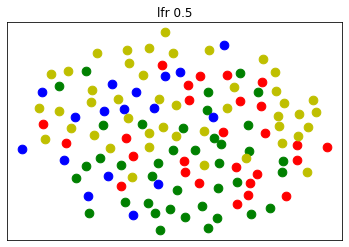

In [48]:
G=G_lfr
pos=nx.spring_layout(G)
# print(pos)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[0],node_color='r',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='g',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='b',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='y',node_size=75)

plt.title('lfr 0.5')
plt.show()

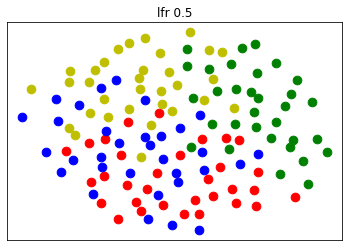

In [49]:
c_groups=[]
c_attributes = nx.get_node_attributes(G_lfr,'value')
for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)
        
X_gt = np.array(c_groups)
labels_dict={1:[],2:[],3:[],4:[]}
for index,item in enumerate(X_gt):
    labels_dict[item].append(index+1)

G=G_lfr
pos=nx.spring_layout(G)
# print(pos)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[1],node_color='r',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[2],node_color='g',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[3],node_color='b',node_size=75)
nx.draw_networkx_nodes(G,pos,nodelist=labels_dict[4],node_color='y',node_size=75)

plt.title('lfr 0.5')
plt.show()